##Object Detection

Instead of printing out the bounding box coordinate, visualize the bounding boxes on top of the image 

##Imports 

In [4]:
import tensorflow as tf
import tensorflow_hub as hub

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps

import time



##Select and Load the Model

In [2]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

##Load the model 

Load the model that was specified by `module_handle`

In [5]:
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


##Choose the signature 

In [25]:
detector = model.signatures['default']

##Download and Resize the Image

`download_and_resize_image` downloads an image specified by a given url, pre-processes it, and saves it to a disk
* The difference between this one and the previous utility is that it can set the image to be displayed by changing the parameter `display=True`

In [14]:
def display_image(image):
  """
  Displays an image inside the notebook
  Used by the `download_and_resize_image` function
  """

  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)

In [10]:
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
  """
  Fetches an image online, resizes it and saves it locally

  Args:
    url (string): link to the image 
    new_width (int): size in pixels used for resizing the width of the image
    new_height (int): size in pixels used for resizing the length of the image

  Returns:
    (string): path to the saved image
  """

  #create a temporary file ending in .jpg
  _, filename = tempfile.mkstemp(suffix = '.jpg')

  #opens the given URL
  response = urlopen(url)

  #reads the image fetched from the URL
  image_data = response.read()

  #Puts the image data in a memory buffer
  image_data = BytesIO(image_data)

  #opens the image
  pil_image = Image.open(image_data)
  
  #Resizes the image and will crop if aspect ratio changes
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)

  #Converts to the RGB colorspace
  pil_image_rgb = pil_image.convert('RGB')

  #Saves the image to the temporary file created earlier 
  pil_image_rgb.save(filename, format='JPEG', quality=90)

  if display:
    display_image(pil_image)

  return filename

##Display and load an image

In [15]:
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"  #@param
downloaded_image_path = download_and_resize_image(image_url, 1280, 856, True)

Output hidden; open in https://colab.research.google.com to view.

##Draw Bounding Boxes

Use `draw_boxes` to visualize the predicted bounding boxes overlaid on top of the image and use `draw_bounding_box_on_image` to draw the bounding boxes

In [16]:
def draw_bounding_box_on_image(image,
                               y_min,
                               x_min,
                               y_max,
                               x_max,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """
  Adds a bounding box to an image.

  Args:
    image -- the image object.
    y_min, x_min, y_max, x_max -- bouding box coordinates.
    color -- color for the bounding box edges.
    font -- font for class label.
    thickness -- edge thickness of the bounding box.
    display_str_list -- class labels for each object detected.
  
  Returns:
    No return.
  """
  draw = ImageDraw.Draw(image)

  img_width, img_height = image.size

  # scale the bouding box coordinates to the height and width of the image
  (left, top, right, bottom) = (x_min * img_width, y_min * img_height,
                                x_max * img_width, y_max * img_height)
  
  # define the four edges of the detection box
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), 
             (left, top)], width=thickness, fill=color)
  
  # If the total height of the display string added to the top of the bounding
  # box exceeds the top of the image, stack the string below the bouding box instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height

  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
   
    text_width, text_height = font.getsize(display_str)
    
    margin = np.ceil(0.05 * text_height)
    
    draw.rectangle([(left, text_bottom - text_height - 2* margin),
                    (left + text_width, text_bottom),
                    ],fill=color)
    
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
   
    text_bottom -= text_height - 2 * margin

In [17]:
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """
  Overlay labeled boxes on an image with formatted scores and label names.

  Args: 
    image -- the image as a numpy array
    boxes -- list of detection boxes
    class_names -- list of classes for each detected object
    scores -- numbers showing the model's confidence in detecting that object
    max_boxes -- maximum detection boxes to overlay on the image (default is 10)
    min_score -- minimum score required to display a bounding box

  Returns:
    image -- the image after detection boxes and classes are overlaid on the ogirinal
    image
  """
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    # only display detection boxes that have the minimum score or higher
    if scores[i] >= min_score:
      y_min, x_min, y_max, x_max = tuple(boxes[i])
      display_str = "{}: {}".format(class_names[i].decode("ascii"),
                                    int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

      # draw one bounding box and overlay the class labels onto the image
      draw_bounding_box_on_image(image_pil,
                                 y_min, x_min, y_max, x_max,
                                 color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))

  return image

##Run Detector 

`run_detector` will take in the object detection model `detector` and the path to a sample image and use this model to detect objects 

* `run_detector` also calls `draw_boxes` to draw the predicted bounding boxes

In [19]:
def load_img(path):
  """
  Loads a JPEG image and converts it to a tensor 

  Args:
    path (string): path to a locally saved JPEG image

  Returns:
    (tensor): an image tensor 
  """

  #read the file 
  img = tf.io.read_file(path)

  #Convert to tensor
  img = tf.image.decode_jpeg(img, channels=3)

  return img

In [23]:
def run_detector(detector, path):
  """
  Runs inference on a local file using an object detection model

  Args:
    detector (model): an object detection model loaded from TF Hub
    path (string): path to an image saved locally
  """

  #load an image tensor from a local file path
  img = load_img(path)

  #add a batch dimension in front of the tensor
  converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]

  #runs inference using the model 
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  #Save the results in a dictionary
  result = {key: value.numpy() for key, value in result.items()}

  #print results 
  print('Found %d objects.' % len(result['detection_scores']))
  print('inference time:', end_time - start_time)

  #draw predicted boxes over the image
  image_with_boxes = draw_boxes(
      img.numpy(), result['detection_boxes'],
      result['detection_class_entities'], result['detection_scores']
      )
  
  #display the image
  display_image(image_with_boxes)

##Run the detector on the selected image 

In [26]:
run_detector(detector, downloaded_image_path)

Output hidden; open in https://colab.research.google.com to view.

##Try other images

In [27]:
image_urls = [
  # Source: https://commons.wikimedia.org/wiki/File:The_Coleoptera_of_the_British_islands_(Plate_125)_(8592917784).jpg
  "https://upload.wikimedia.org/wikipedia/commons/1/1b/The_Coleoptera_of_the_British_islands_%28Plate_125%29_%288592917784%29.jpg",
  # By Américo Toledano, Source: https://commons.wikimedia.org/wiki/File:Biblioteca_Maim%C3%B3nides,_Campus_Universitario_de_Rabanales_007.jpg
  "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg/1024px-Biblioteca_Maim%C3%B3nides%2C_Campus_Universitario_de_Rabanales_007.jpg",
  # Source: https://commons.wikimedia.org/wiki/File:The_smaller_British_birds_(8053836633).jpg
  "https://upload.wikimedia.org/wikipedia/commons/0/09/The_smaller_British_birds_%288053836633%29.jpg",
  ]

def detect_img(image_url):
    start_time = time.time()
    image_path = download_and_resize_image(image_url, 640, 480)
    run_detector(detector, image_path)
    end_time = time.time()
    print("Inference time:",end_time-start_time)

Found 100 objects.
inference time: 30.621548414230347
Inference time: 31.10709309577942


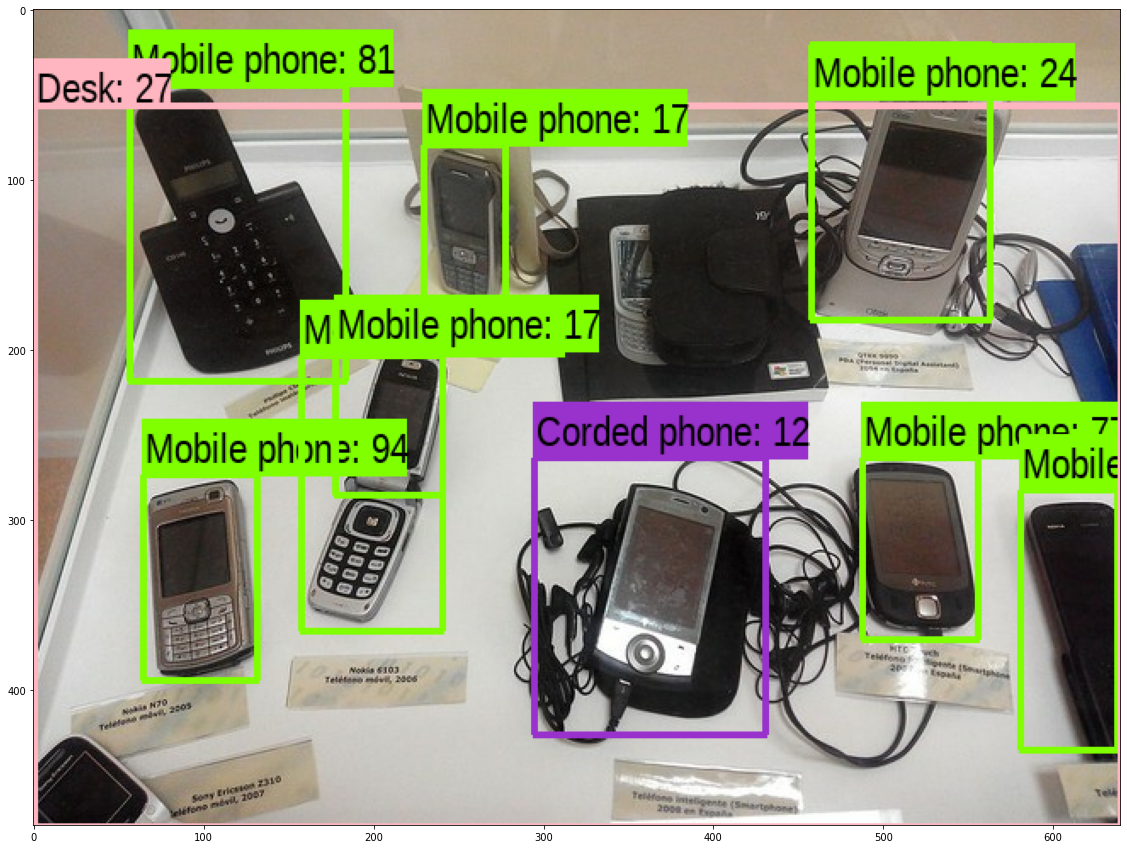

In [29]:
detect_img(image_urls[1])